In [8]:
! pip install "gymnasium[other]

   ---------------------------------------- 0.0/39.5 MB ? eta -:--:--
   --- ------------------------------------ 3.1/39.5 MB 15.3 MB/s eta 0:00:03
   ------ --------------------------------- 6.3/39.5 MB 16.1 MB/s eta 0:00:03
   --------- ------------------------------ 9.4/39.5 MB 15.8 MB/s eta 0:00:02
   ------------- -------------------------- 13.1/39.5 MB 16.1 MB/s eta 0:00:02
   ---------------- ----------------------- 16.5/39.5 MB 16.0 MB/s eta 0:00:02
   -------------------- ------------------- 19.9/39.5 MB 15.9 MB/s eta 0:00:02
   ----------------------- ---------------- 23.6/39.5 MB 16.0 MB/s eta 0:00:01
   --------------------------- ------------ 27.0/39.5 MB 16.1 MB/s eta 0:00:01
   ------------------------------- -------- 30.7/39.5 MB 16.2 MB/s eta 0:00:01
   ---------------------------------- ----- 34.3/39.5 MB 16.3 MB/s eta 0:00:01
   -------------------------------------- - 37.7/39.5 MB 16.2 MB/s eta 0:00:01
   ---------------------------------------  39.3/39.5 MB 16.2 MB

  You can safely remove it manually.


In [ ]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import gymnasium as gym
from stable_baselines3 import PPO, A2C
from sb3_contrib import TRPO

# HalfCheetah environment
env = gym.make("HalfCheetah-v5")

print("Observation space:", env.observation_space)
print("Action space:", env.action_space)

Observation space: Box(-inf, inf, (17,), float64)
Action space: Box(-1.0, 1.0, (6,), float32)


In [39]:
from stable_baselines3.common.callbacks import BaseCallback

class EpisodeRewardLogger(BaseCallback):
    def __init__(self, verbose=0):
        super().__init__(verbose)
        self.episode_rewards = []

    def _on_step(self) -> bool:
        # 'infos' is a list (for each env in a VecEnv)
        infos = self.locals.get("infos", [])
        for info in infos:
            # If an episode ended, info has the "episode" key
            if "episode" in info.keys():
                ep_reward = info["episode"]["r"]
                self.episode_rewards.append(ep_reward)
                if self.verbose > 0:
                    print(f"Episode Reward: {ep_reward}")
        return True



In [40]:
models = {
    "PPO": PPO("MlpPolicy", env, verbose=1),
    "TRPO": TRPO("MlpPolicy", env, verbose=1),
    "A2C": A2C("MlpPolicy", env, verbose=1)
}

rewards = {
    "PPO": EpisodeRewardLogger(),
    "TRPO": EpisodeRewardLogger(),
    "A2C": EpisodeRewardLogger()
}

timesteps = int(1e6)

for name, model in models.items():
    print(f"Training {name} on HalfCheetah...")
    model.learn(total_timesteps=timesteps, callback=rewards[name])
    model.save(f"{name}_halfcheetah")
    print(f"{name} training complete!\n")


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Training PPO on HalfCheetah...
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.6     |
|    ep_rew_mean     | -1.03    |
| time/              |          |
|    fps             | 1509     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 20.4        |
|    ep_rew_mean          | 1.74        |
| time/                   |             |
|    fps                  | 1088        |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_

In [41]:
import numpy as np

def evaluate(model, env, episodes=10):
    rewards = []
    for _ in range(episodes):
        obs, _ = env.reset()
        done, total_reward = False, 0
        while not done:
            action, _ = model.predict(obs)
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward
        rewards.append(total_reward)
    return np.mean(rewards)

# Evaluate all models
for name in models.keys():
    model = models[name].load(f"{name}_halfcheetah")
    avg_reward = evaluate(model, env)
    print(f"{name} Avg Reward: {avg_reward:.2f}")


PPO Avg Reward: 942.16
TRPO Avg Reward: 1609.77
A2C Avg Reward: 159.31


In [ ]:
# Load the trained model
models = {
    "PPO": PPO.load("PPO_halfcheetah.zip"), 
    "TRPO": TRPO.load("TRPO_halfcheetah.zip"),
    "A2C": A2C.load("A2C_halfcheetah.zip")
}

print("Models loaded successfully!")

Models loaded successfully!


In [44]:
from gymnasium.wrappers import RecordVideo

# Load trained PPO model
ppo_model = PPO.load("PPO_halfcheetah.zip")

# Create HalfCheetah environment with video recording enabled
video_env = gym.make("Walker2d-v5", render_mode="rgb_array")
video_env = RecordVideo(video_env, video_folder="./video/", episode_trigger=lambda x: True)

# Run a test episode
obs, _ = video_env.reset()
done = False
while not done:
    action, _ = ppo_model.predict(obs)
    obs, reward, terminated, truncated, _ = video_env.step(action)
    done = terminated or truncated

video_env.close()
print("Video recorded! Check the './videos/' folder.")


c:\Users\Main_YnFb\anaconda3\envs\tf\lib\site-packages\gymnasium\wrappers\rendering.py:283: UserWarning: WARN: Overwriting existing videos at d:\Telecom\M2DS\RL\video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Video recorded! Check the './videos/' folder.


In [18]:
import os
from IPython.display import Video

video_path = "./videos/rl-video-episode-0.mp4"  # Change based on filename
if os.path.exists(video_path):
    display(Video(video_path))
else:
    print("Video file not found.")

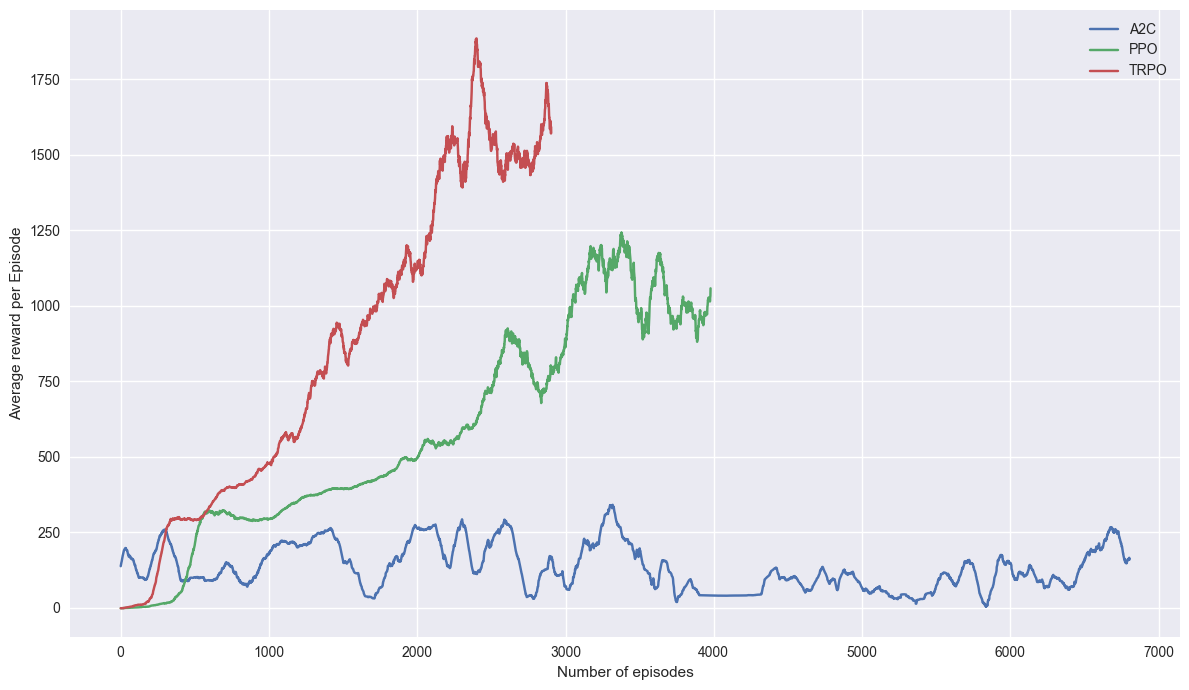

In [47]:
WINDOW_SIZE = 100
def moving_average(data, window_size=WINDOW_SIZE):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

rewards_PPO = moving_average(rewards['PPO'].episode_rewards)
rewards_TRPO = moving_average(rewards['TRPO'].episode_rewards)
rewards_A2C = moving_average(rewards['A2C'].episode_rewards)

import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')

fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(rewards_A2C, label='A2C')
ax.plot(rewards_PPO, label='PPO')
ax.plot(rewards_TRPO, label='TRPO')
ax.set_xlabel('Number of episodes')
ax.set_ylabel('Average reward per Episode')
ax.grid()
plt.grid()
ax.legend()
fig.tight_layout()
plt.show()

